# Fish Image Classification with Using Simple ANN Architecture

**This project aims to classify images of various fish species using a basic Artificial Neural Network (ANN) model. The task involves processing image data as input, applying appropriate preprocessing steps, and developing a model to accurately predict the fish species from the images. While advanced techniques like Convolutional Neural Networks (CNNs) and transfer learning (ResNet, EfficientNet, MobileNet) could be employed, the focus of this study is to evaluate the effectiveness of image classification using a simple ANN architecture.**

**Notes**

**Although the dataset information was provided, I approached it as if the images were scraped from the internet and processed the data with that in mind. Therefore, methods like smart cropping and image clustering, which are not necessary for this dataset, were applied for demonstration purposes.**

**All helper functions used in this study are thoroughly documented in the corresponding docstrings.**

**During the model training process, the `Training Device: GPU P100` provided by Kaggle was utilized to accelerate computation and improve training efficiency.**

**If you don't want to wait for the model training, I have uploaded the trained model to the Kaggle environment (`fish_classification_ann_model`). In section 4, activate the related command line.**

```
model = load_model("/kaggle/working/models/best_model.keras")
# model = load_model("/kaggle/input/fish_classification_ann_model/keras/default/1/best_model.keras")
```

**Technologies Used:**

- **Programming Language:** Python

- **Libraries:**
  - **TensorFlow (Keras API):** For model training and neural network implementation.
  - **Scikit-learn:** Used for scoring metrics, Principal Component Analysis (PCA), and KMeans clustering.
  - **Matplotlib & Seaborn:** Employed for data visualization and graphical representation.
  - **NumPy & Pandas:** For numerical computations and data manipulation.
  - **Pillow & OpenCV:** Utilized for image processing tasks.
  - **Other Helper Libraries:** Various additional Python libraries to support auxiliary tasks.

**Project Github Repo**

https://github.com/kanitvural/fish_classification_akbank


### Steps:

1. **Data Collection and Validation:**
   
   The dataset used contains images of 9 different fish species, created and uploaded by O. Ulucan, D. Karakaya, and M. Turkan from Izmir University of Economics. Dataset includes, gilt head bream, red sea bream, sea bass, red mullet, horse mackerel, black sea sprat, striped red mullet, trout, shrimp image samples. The images are resized to 590 x 445 pixels and are publicly available on Kaggle.
   The original images are located in folders ending with "GT," but they were not used in this study.


2. **Exploratory Data Analysis and Visualization:**

   Before preprocessing, the image dimensions and color channels were analyzed, and necessary visualizations were created.

3. **Image Preprocessing:**

   Image data must be preprocessed before feeding it into the ANN.
   
   First, `smart cropping` was applied to center the fish images and eliminate unnecessary parts. Then, considering that unrelated images might be mixed in with the fish images, the embeddings of the images were extracted, followed by dimensionality reduction using `PCA`. After that, `K-means clustering`  was applied to classify the images. As a result of the classification, no images that could not be used in the model were detected.

4. **Artificial Neural Network (ANN) Model Creation:**

    The Fish dataset has been split into training, validation, and test sets, comprising 80% for training, 10% for validation, and 10% for testing. The training and validation sets are used during the training process, while the test set is reserved for evaluation and prediction.
    
    To prevent overfitting, dropout and batch normalization techniques were applied.
    
    Early stopping, learning rate decay, and TensorBoard callbacks were utilized. Early stopping was implemented to prevent prolonged training times, while learning rate decay (ReduceLROnPlateau) was used to reduce the learning rate if there was no improvement in training progress. The TensorBoard callback was employed to monitor training results; however, since it does not work on Kaggle notebooks, the history object was used for visualization instead.

   Selected Hyperparameters:
   
      ```
        - Number of Layers: 6
        - Number of Neurons: 512, 256, 256, 128, 64, 10
        - Batch size: 32
        - Activation Function: relu
        - Optimization Algorithm: Adam
        - Learning Rate: 0.01 with decay
        - Image size: 128 x 128
    ```
    Selected Performance Metric: `Accuracy`
    

6. **Conclusions and Recommendations:**
   
    The results of this study indicate that the simple Artificial Neural Network (ANN) model successfully classified fish species from images with %91 accuracy.
    
    - Model Enhancement: The number of layers and dropout rates of the ANN model can be adjusted to achieve better results. Due to out-of-memory errors, no attempts were made after reaching 91% accuracy. Additionally, CNN layers can be added to the model, or transfer learning can be performed using well-known model architectures to achieve better results.
      
    - Hyperparameter Tuning: Automating hyperparameter tuning using Bayesian optimization or grid search could lead to better model performance.
      
    - Scaling Resources: If computational resources allow, parallel processing or cloud-based solutions can be used for faster model training and hyperparameter search.

In [1]:
import os
import random
import shutil
import glob
import logging
from tqdm import tqdm
from itertools import compress
from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image
import cv2 as cv
from scipy.cluster.vq import kmeans2
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Layer, Flatten, LeakyReLU, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras import saving

pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))
%load_ext tensorboard

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.19.0
GPU is NOT AVAILABLE


## 1. Data Collection and Validation:

- The quantities and names of the fish classes mentioned in the dataset have been verified in this section.

In [3]:
fish_dataset_directory ="/content/train/"

In [4]:
def find_image_classes(images_path: str) -> List[str]:
    """
    Find subdirectory names in the specified directory.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories.

    Returns
    -------
    List[str]
        A list of subdirectory names found within the specified directory.

    Example
    -------
    classes = find_image_classes("path/to/fish_dataset_directory")
    print(classes)
    """
    return [i for i in os.listdir(images_path) if os.path.isdir(os.path.join(images_path, i))]


In [5]:
image_classes = find_image_classes(fish_dataset_directory)
image_classes

['merisiig', '.ipynb_checkpoints', 'siirdesiig']

In [14]:
def df_from_image_folders(images_path: str, extensions: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Create a DataFrame from image files in specified directories.

    Parameters
    ----------
    images_path : str
        Path to the directory containing subdirectories of images.
    extensions : List[str], optional
        A list of file extensions of the images to include (default is ["jpg", "jpeg", "png"]).

    Returns
    -------
    pd.DataFrame
        A DataFrame with two columns: 'path' containing file paths and 'label' containing the class labels.

    Notes
    -----
    Excludes directories that contain 'GT' in their names.

    Example
    -------
    df = df_from_image_folders("path/to/fish_dataset_directory", extensions=["jpg", "png"])
    print(df.head())
    """

    if extensions is None:
        extensions = ["jpg", "jpeg", "png"] # Default extensions

    label = []
    path = []
    image_files = []

    for ext in extensions:
        image_files.extend(glob.glob(os.path.join(images_path, "**", f"*.{ext.lower()}"), recursive=True))

    for file in image_files:
        dirpath = os.path.dirname(file)
        folder_name = os.path.basename(dirpath)
        if "GT" not in folder_name:
            label.append(folder_name)
            path.append(file)

    class_dict = {"path": path, "label": label}
    return pd.DataFrame(class_dict)

In [15]:
df = df_from_image_folders(fish_dataset_directory, extensions=["jpg", "png"])
df.head()
#df.tail()

,path,label
0,/content/train/merisiig/S202014_fish_1.jpg,merisiig
1,/content/train/merisiig/R202015_fish_1.jpg,merisiig
2,/content/train/merisiig/KU201704_fish_1.jpg,merisiig
3,/content/train/merisiig/R202005_fish_1.jpg,merisiig
4,/content/train/merisiig/R202009_fish_1.jpg,merisiig


In [18]:
def display_fish_from_each_class(df: pd.DataFrame, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays one image from each unique class in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and labels.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    """

    plt.figure(figsize=(12, 12))

    for i, unique_label in enumerate(df["label"].unique()):

        plt.subplot(3, 3, i + 1)
        image_path = df[df["label"] == unique_label].iloc[0, 0]
        img = load_img(image_path, target_size=img_size)
        plt.imshow(img)
        plt.title(unique_label)
        plt.axis('off')

    plt.show()

**Validation fo the 9 different fish species**

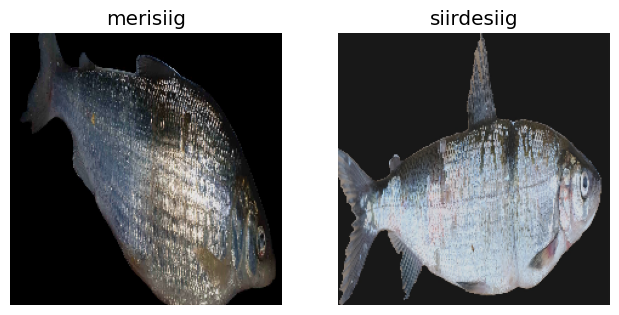

In [19]:
display_fish_from_each_class(df)

In [20]:
def display_images_from_class(df: pd.DataFrame, class_name: str, num_images: int, img_size: Tuple[int, int] = (224, 224)) -> None:
    """
    Displays a specified number of images from a given class in the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and labels.
    class_name : str
        The class label to filter the images.
    img_size : Tuple[int, int]
        Size to which images will be resized for display.
    num_images : int
        Number of images to display from the given class.
    """
    images = df[df["label"] == class_name]["path"].iloc[:num_images]
    plt.figure(figsize=(12, 12))

    for i, image_path in enumerate(images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(load_img(image_path, target_size=img_size))
        plt.title(image_path[-5:-4])
        plt.axis('off')

    plt.show()


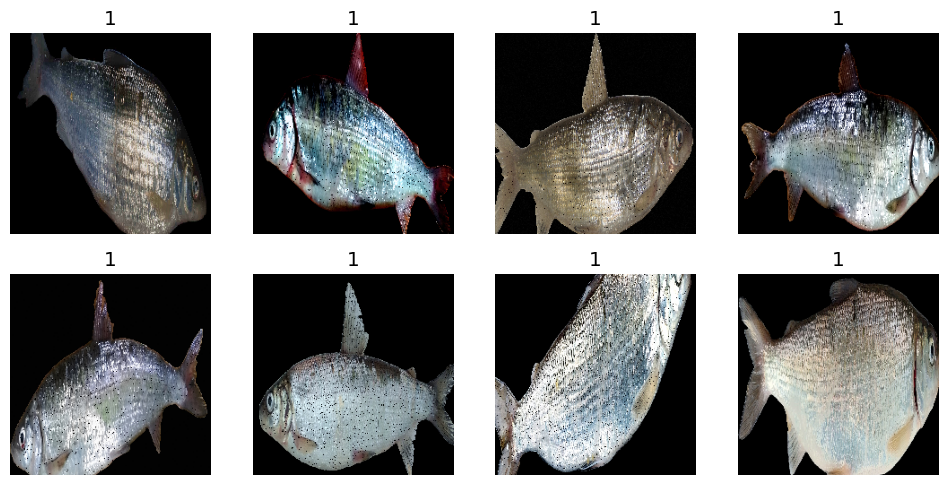

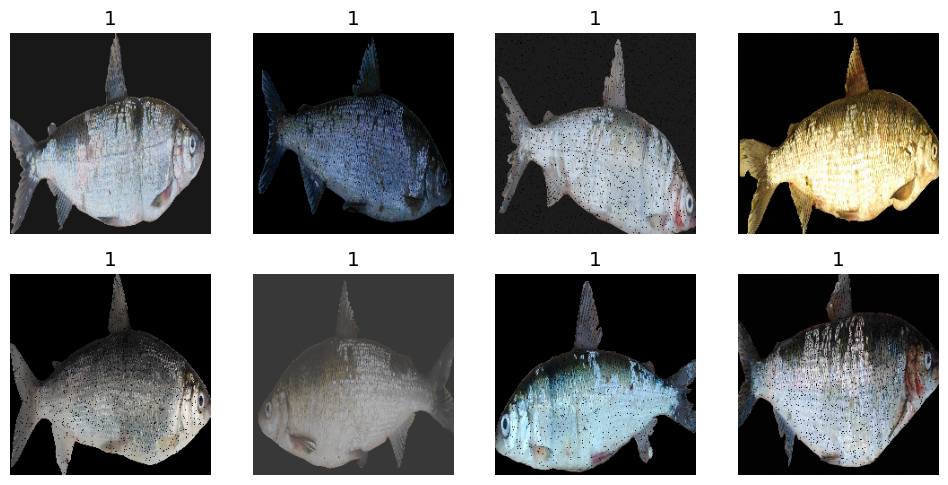

In [21]:
display_images_from_class(df, "merisiig", 8)
display_images_from_class(df, "siirdesiig", 8)

**Validation of the 9 unique class**

In [22]:
df["label"].nunique()

2

**Validation of the fish class names**

In [23]:
df[["label"]].value_counts()

,count
label,
siirdesiig,222
merisiig,184


**Validation graph of the image counts**

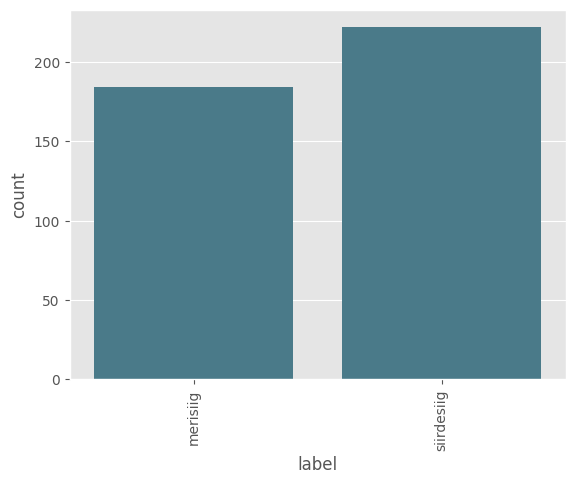

In [24]:
sns.countplot(x="label", data = df )
plt.xticks(rotation = 90)
plt.show()

## 2. Exploratory Data Analysis and Visualization:

### 2.1. Analysis of Image Sizes and Channels:

- The purpose of this study is to standardize images if they are different sizes. Using the created function below, it has been determined that all images have the same standard size.

In [ ]:

def compute_image_statistics_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes average width, height, and channel count for images listed in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'path' and 'label' columns for images.

    Returns:
        pd.DataFrame: DataFrame containing average statistics for each fish class.
    """
    stats = []

    grouped = df.groupby('label')

    for label, group in grouped:
        widths = []
        heights = []
        channel_counts = []

        for _, row in group.iterrows():
            image_path = row['path']
            try:
                image = load_img(image_path)
                image_array = img_to_array(image)

                width, height = image.size
                widths.append(width)
                heights.append(height)
                channel_counts.append(image_array.shape[2])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

        if widths:
            avg_width = np.mean(widths)
            avg_height = np.mean(heights)
            avg_channels = np.mean(channel_counts)
            min_width = np.min(widths)
            max_width = np.max(widths)
            min_height = np.min(height)
            max_height = np.max(height)

            stats.append({
                'Fish Class': label,
                'Average Width': avg_width,
                'Average Height': avg_height,
                'Average Channels': avg_channels,
                'Min Width': min_width,
                'Max Width' : max_width,
                'Min Height' : min_height,
                'Max Height' : max_height
            })

    return pd.DataFrame(stats)


In [ ]:
df_statistics = compute_image_statistics_from_df(df)
df_statistics

,Fish Class,Average Width,Average Height,Average Channels,Min Width,Max Width,Min Height,Max Height
0,merisiig,3921.021739,1112.717391,3.0,1655,4819,1386,1386
1,siirdesiig,3188.450450,1076.099099,3.0,1833,4849,880,880


### 2.2. Visualization of the image rgb channels

In [ ]:
def display_rgb_channels(image_path: str) -> None:
    """
    Displays the individual RGB channels of an image.

    Parameters
    ----------
    image_path : str
        The file path to the image.

    Returns
    -------
    None
    """
    image = Image.open(image_path)

    r, g, b = image.split()

    r_array = np.array(r)
    g_array = np.array(g)
    b_array = np.array(b)

    fig, axes = plt.subplots(1, 3, figsize=(12,12))

    axes[0].imshow(r_array, cmap="Reds")
    axes[0].set_title("Red Channel")
    axes[0].axis("off")

    axes[1].imshow(g_array, cmap="Greens")
    axes[1].set_title("Green Channel")
    axes[1].axis("off")

    axes[2].imshow(b_array, cmap="Blues")
    axes[2].set_title("Blue Channel")
    axes[2].axis("off")


    plt.show()


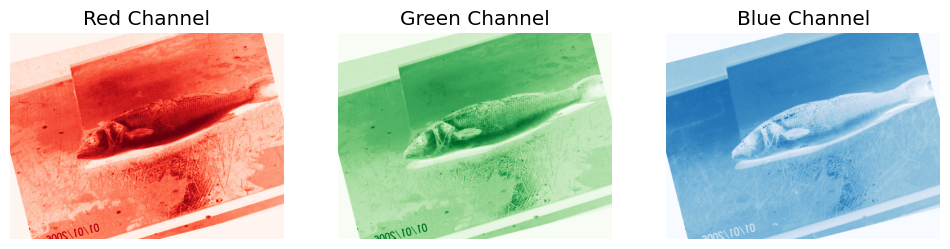

In [ ]:
sample_image = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00026.png"
display_rgb_channels(sample_image)

### 2.3. Histogram of the each fish species images pixel distribution:

- As can be seen from the pixel distribution histogram graphs, each species has different color distributions

In [ ]:
def plot_average_pixel_distribution_from_df(df: pd.DataFrame, target_size: tuple = (150, 150)) -> None:
    """
    Plots average pixel value distribution for each class based on a DataFrame containing image paths and labels.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'path' and 'label' columns.
    target_size (tuple): Size to which each image will be resized (default is (150, 150)).

    Returns:
    None: Displays the average pixel value histograms for each class.
    """

    unique_labels = df['label'].unique()
    plt.figure(figsize=(15, 10))

    for i, label in enumerate(unique_labels):

        class_images = df[df['label'] == label]['path'].values
        pixel_values = []

        for image_path in class_images:
            image = load_img(image_path, target_size=target_size)
            image_array = img_to_array(image)
            pixel_values.append(image_array)

        pixel_values = np.array(pixel_values)
        avg_pixel_values = np.mean(pixel_values, axis=(0, 1, 2))

        plt.subplot(3, 3, i + 1)
        plt.hist(avg_pixel_values, bins=50, range=(0, 255), color='blue', alpha=0.7)
        plt.title(f'{label} Pixel Value Distribution')
        plt.xlabel('Pixel Value (0-255)')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

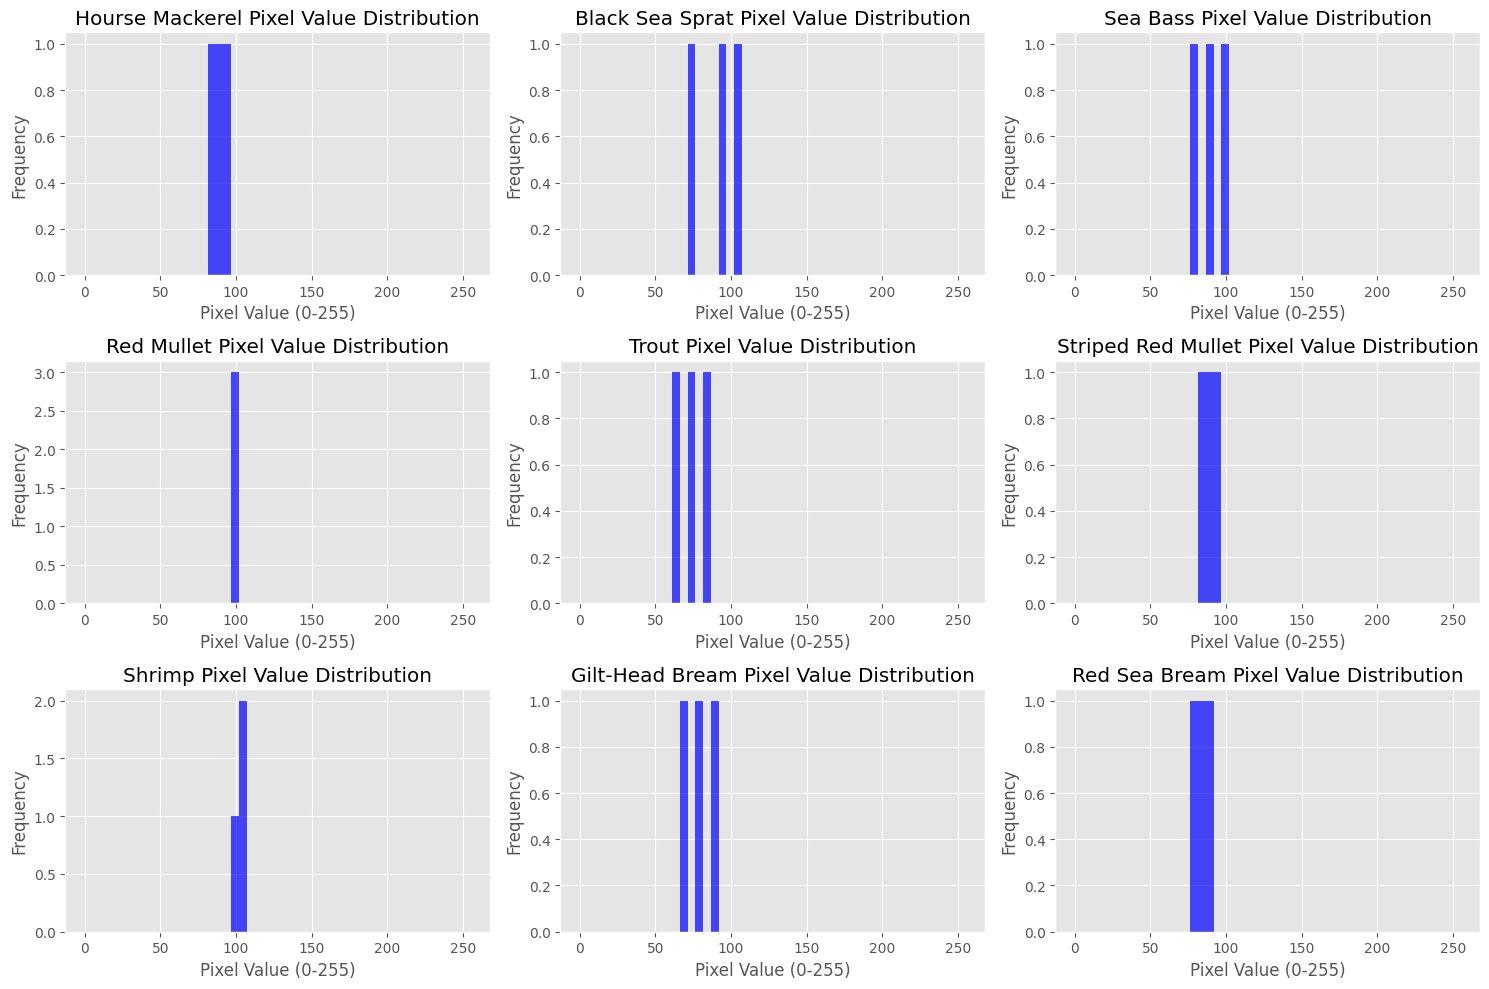

In [ ]:
plot_average_pixel_distribution_from_df(df)

## 3. Image Preprocessing:

Since there are a large number of images in the dataset, preprocessing steps have been carried out to filter these images in the best possible way.Cropping, embedding, clustering, splitting, normalization, and data augmentation processes have been applied. Since all images are of the same size, a min-max resolution filter has not been applied. If these images had been scraped from the internet with different sizes, all images could have been resized to the same dimensions.

### 3.1. Image Cropping

This section aims to show how smart cropping works. `Smart cropping`, removes the unneccessary parts of the image and focuses the main object of the image. For this purpose all images converted to PIL image.

**Image Cropping Demo**




In [25]:
# logging.basicConfig(
#     level=logging.INFO, format= "%(asctime)s - %(levelname)s - %(message)s"
# )


def load_image(image_path: str) -> Image.Image:
    """
    Load an image in RGB format from the given path.

    Parameters
    ----------
    image_path : str
        Path to the image file.

    Returns
    -------
    Image.Image
        Loaded image.
    """
    image = Image.open(image_path).convert("RGB")
    return image

def load_images_from_df(df: pd.DataFrame) -> List[Image.Image]:
    """
    Load images from a DataFrame containing image paths.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with a column "path" for image file paths.

    Returns
    -------
    List[Image.Image]
        List of loaded images.
    """
    images = [load_image(image_path) for image_path in tqdm(df["path"].values.tolist(), total=len(df))]
    # logging.info(f"Loaded {len(images)} images from DataFrame")
    return images

In [26]:
loaded_images = load_images_from_df(df)

100%|██████████| 406/406 [00:46<00:00,  8.78it/s]


In [27]:
def plot_image(image: Image.Image) -> None:
    """
    Display an image using matplotlib with the axis turned off.

    Parameters
    ----------
    image : Image.Image
        The image to be displayed.

    Returns
    -------
    None
    """
    plt.imshow(image)
    plt.axis("off")
    plt.show()

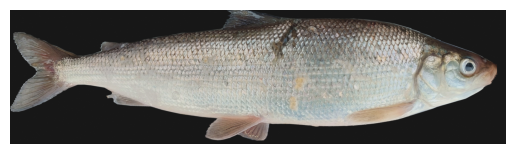

In [29]:
plot_image(loaded_images[20])

**Smart Crop Script**

In [30]:

EXTENSIONS = ("jpg", "JPG", "jpeg", "JPEG", "png", "PNG")

def detect(pil_image: Image.Image, square: bool = False) -> np.ndarray:
    """
    Detect keypoints in the image using SIFT and apply cropping.

    Parameters
    ----------
    pil_image : Image.Image
        The input image to detect keypoints and crop.
    square : bool, optional
        If True, the output image will be square-shaped. Defaults to False.

    Returns
    -------
    np.ndarray
        The cropped image as a numpy array.
    """
    img = np.array(pil_image)
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    sift = cv.SIFT_create(edgeThreshold=8)
    kp = sift.detect(gray, None)

    all_points = [i.pt for i in kp]
    x_points = [z[0] for z in all_points]
    y_points = [z[1] for z in all_points]
    thresh = 0
    x_min, y_min = int(min(x_points)) - thresh, int(min(y_points) - thresh)
    x_max, y_max = int(max(x_points)) + thresh, int(max(y_points) + thresh)
    min_side = min((x_max - x_min), (y_max - y_min))
    max_side = max((x_max - x_min), (y_max - y_min))
    x_mean, y_mean = int((x_max + x_min) / 2), int((y_max + y_min) / 2)

    squared_x_min, squared_x_max = x_mean - int(min_side / 2), x_mean + int(min_side / 2)
    squared_y_min, squared_y_max = y_mean - int(min_side / 2), y_mean + int(min_side / 2)

    if not square:
        return img[y_min:y_max, x_min:x_max]

    return img[squared_y_min:squared_y_max, squared_x_min:squared_x_max]

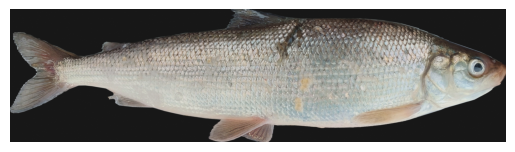

In [31]:
cropped_image = detect(loaded_images[20], square=False)
plot_image(cropped_image)

**Applying Image Cropping to The All Images and Saving Them to Disk**

In [32]:
def crop_image(image: Image.Image, square: bool = True) -> Image.Image:
    """
    Apply smart cropping to the image using SIFT keypoints detection.

    Parameters
    ----------
    image : Image.Image
        The image to be processed and cropped.
    square : bool, optional
        If True, the output image will be square-shaped. Defaults to True.

    Returns
    -------
    Image.Image
        Cropped image based on detected keypoints.
    """
    cropped_image = detect(image, square=square)
    return Image.fromarray(cropped_image)

def create_directory(dir_path: str) -> None:
    """
    Create a directory if it doesn't exist.

    Parameters
    ----------
    dir_path : str
        The path of the directory to create.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)


def save_image(image: Image.Image, save_path: str) -> None:
    """
    Save a PIL image to a specific path.

    Parameters
    ----------
    image : Image.Image
        The image to save.
    save_path : str
        The path where the image should be saved.
    """
    image.save(save_path)

# Main Function
def process_and_save_images(df: pd.DataFrame, output_base_dir: str) -> None:
    """
    Load, process, and save images organized by labels into respective directories.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'path' and 'label' columns for images and their labels.
    output_base_dir : str
        The base directory where images will be saved, organized by labels.
    """
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row['path']
        label = row['label']

        image = load_image(image_path)

        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        if not isinstance(image, Image.Image):
            raise ValueError("Input image must be a numpy array or PIL image")
        if image.mode != "RGB":
            image = image.convert("RGB")

        processed_image = crop_image(image, square=True)

        label_dir = os.path.join(output_base_dir, label)
        create_directory(label_dir)

        image_name = os.path.basename(image_path)
        save_path = os.path.join(label_dir, image_name)

        save_image(processed_image, save_path)

In [33]:
output_path = "/kaggle/working/preprocessed_images"

In [34]:
process_and_save_images(df, output_path )

100%|██████████| 406/406 [12:15<00:00,  1.81s/it]


**Control**

- All processed images have been controlled using `df_from_image_folders` function that i created before

In [35]:
preprocessed_images = "/kaggle/working/preprocessed_images"
df_preprocessed = df_from_image_folders(preprocessed_images, extensions=["jpg", "png"])
df_preprocessed.head()

,path,label
0,/kaggle/working/preprocessed_images/merisiig/S202014_fish_1.jpg,merisiig
1,/kaggle/working/preprocessed_images/merisiig/R202015_fish_1.jpg,merisiig
2,/kaggle/working/preprocessed_images/merisiig/KU201704_fish_1.jpg,merisiig
3,/kaggle/working/preprocessed_images/merisiig/R202005_fish_1.jpg,merisiig
4,/kaggle/working/preprocessed_images/merisiig/R202009_fish_1.jpg,merisiig


In [36]:
df_preprocessed["label"].value_counts()

,count
label,
siirdesiig,222
merisiig,184


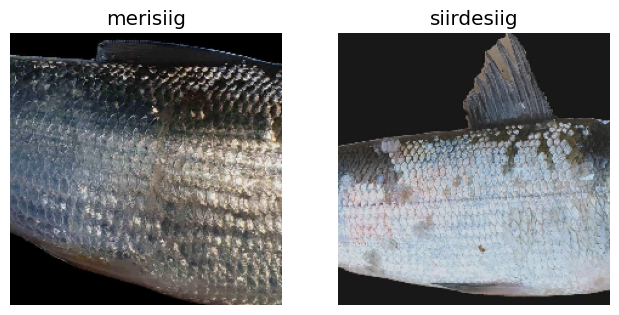

In [37]:
display_fish_from_each_class(df_preprocessed)

### 3.2. Image Clustering

Unwanted images that are not suitable for the model may be mixed in the data. Since we cannot manually check and separate a large number of images one by one, we can classify the images using unsupervised learning techniques to more easily remove these images from the dataset.

To do this, we first need to extract the embeddings of the images. The `ResNet50` model has been used for embedding extraction. The final softmax layer of the ResNet50 model has been removd, and the embeddings from the fully connected layer with 2048 units have been obtained. That s, the values of `Z = WA + b`, which pass through the activation function. Since the size of the embeddings vectors is 2048, it is necessary to reduce the dimensions of these vectors. The more we reduce the dimensions, the more suitable the data becomes for clustering.

`PCA` has been used for the dimensionality reduction process. It is necessary to perform standardization before `PCA` and `K-means`. However, since our data already came from `ResNet50` in a certain standard, no additional standardization has been performUsing these techniques, the embedding dimensions have been reduced to 16, and each fish species has been divided into 4 separate clustersed.

The clustering process has been successful. The fish images have been classified according to the direction of the photo capture. However, the classification revealed that all images are suitable for model training, with no unsuitable images detected.
*


In [ ]:
class Img2VecKeras:
    def __init__(self):
        """
        Initialize the Img2VecKeras class with the ResNet50 model for embedding extraction.
        """
        base_model = ResNet50(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

    def get_vec(self, img_paths: List[str]) -> np.ndarray:
        """
        Extract embeddings for the given list of image paths.

        Parameters
        ----------
        img_paths : List[str]
            A list of paths to the images for which embeddings are to be extracted.

        Returns
        -------
        np.ndarray
            An array of shape (n_samples, n_features) containing the embeddings.
        """
        embeddings = []
        for img_path in tqdm(img_paths, desc="Extracting Embeddings", unit="image"):
            img = load_image(img_path)
            img = img.resize((224, 224))
            img = image.img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_input(img)
            embedding = self.model.predict(img, verbose=0)
            embeddings.append(embedding.flatten())
        return np.array(embeddings)

def extract_and_save_embeddings_from_df(df: pd.DataFrame, embedding_path: str) -> None:
    """
    Extract embeddings from images using a DataFrame and save them to CSV files.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing image paths and their respective labels.
    embedding_path : str
        The directory where the extracted embeddings will be saved as CSV files.

    Returns
    -------
    None
    """

    if not os.path.exists(embedding_path):
        os.makedirs(embedding_path)

    grouped = df.groupby("label")

    for label, group in grouped:
        img_paths = group['path'].tolist()

        img2vec_keras = Img2VecKeras()
        embeddings = img2vec_keras.get_vec(img_paths)

        df_embeddings = pd.DataFrame(embeddings)
        df_embeddings["filepaths"] = img_paths

        output_file = os.path.join(embedding_path, f"{label}_embeddings.csv")
        df_embeddings.to_csv(output_file, index=False)
        #print(f"Saved embeddings for {label} to {output_file}")


**Extract Embeddings**

In [ ]:
embedding_path = "/kaggle/working/preprocessed_images_embeddings"
extract_and_save_embeddings_from_df(df_preprocessed, embedding_path)

**Load Embeddings**

In [ ]:
def load_embeddings_from_directory(directory: str) -> List[Tuple[np.ndarray, List[str]]]:
    """
    Load embeddings from all CSV files in the specified directory.

    Parameters
    ----------
    directory : str
        Path to the directory containing the CSV files.

    Returns
    -------
    List[Tuple[np.ndarray, List[str]]]
        A list of tuples, each containing embeddings and corresponding file paths from a CSV file.
    """
    all_embeddings = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            embeddings = pd.read_csv(file_path)
            file_paths = embeddings["filepaths"].tolist()
            embeddings = embeddings.drop("filepaths", axis=1).values
            all_embeddings.append((embeddings, file_paths))
    return all_embeddings

def calculate_pca(embeddings: np.ndarray, dim: int = 16) -> np.ndarray:
    """
    Calculate PCA for the given embeddings.

    Parameters
    ----------
    embeddings : np.ndarray
        The input embeddings to be reduced.
    dim : int
        The number of dimensions to reduce to.

    Returns
    -------
    np.ndarray
        The PCA-reduced embeddings.
    """
    print("Calculating PCA")
    pca = PCA(n_components=dim)
    pca_embeddings = pca.fit_transform(embeddings)
    print("PCA calculation done!")
    return pca_embeddings

def calculate_kmeans(embeddings: np.ndarray, k: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform KMeans clustering on the embeddings.

    Parameters
    ----------
    embeddings : np.ndarray
        The input embeddings to be clustered.
    k : int
        The number of clusters.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        A tuple containing the centroids and the labels assigned to each embedding.
    """
    print("KMeans processing...")
    centroids, labels = kmeans2(data=embeddings, k=k, minit="points")
    print("KMeans done!")
    return centroids, labels

def create_dir(directory: str) -> None:
    """
    Create a directory if it does not exist.

    Parameters
    ----------
    directory : str
        The path to the directory to create.

    Returns
    -------
    None
    """
    if not os.path.exists(directory):
        os.makedirs(directory)

def copy_images_to_clusters(image_paths: List[str], labels: np.ndarray, cluster_range: int, class_name: str) -> None:
    """
    Copy images to their corresponding cluster directories.

    Parameters
    ----------
    image_paths : List[str]
        The list of image paths.
    labels : np.ndarray
        The labels assigned to each image by the clustering algorithm.
    cluster_range : int
        The number of clusters.
    class_name : str
        The name of the class for the output directory structure.

    Returns
    -------
    None
    """
    for label_number in tqdm(range(cluster_range)):
        label_mask = labels == label_number
        path_images = list(compress(image_paths, label_mask))
        target_directory = f"clusters/{class_name}/cluster_{label_number}"
        create_dir(target_directory)
        for image_path in path_images:
            shutil.copy2(image_path, target_directory)

def run_clustering(embeddings_dir: str, pca_dim: int = 16, cluster_range: int = 4) -> None:
    """
    Run PCA and KMeans clustering on embeddings in all CSV files within the specified directory
    and copy clustered images to respective directories.

    Parameters
    ----------
    embeddings_dir : str
        Path to the directory containing the embeddings CSV files.
    pca_dim : int
        The dimension for PCA reduction.
    cluster_range : int
        The number of clusters for KMeans.

    Returns
    -------
    None
    """
    all_embeddings = load_embeddings_from_directory(embeddings_dir)

    for index, (embeddings, image_paths) in enumerate(all_embeddings):
        class_name = os.path.basename(os.listdir(embeddings_dir)[index]).replace('.csv', '')
        pca_embeddings = calculate_pca(embeddings=embeddings, dim=pca_dim)
        centroids, labels = calculate_kmeans(pca_embeddings, k=cluster_range)
        copy_images_to_clusters(image_paths, labels, cluster_range, class_name)

**Clustering**

In [ ]:
embeddings_path = "/kaggle/working/preprocessed_images_embeddings"
run_clustering(embeddings_path, pca_dim=16, cluster_range=4)

In [ ]:

def show_images(image_paths: List[str], title: str) -> None:
    """
    Display images from the provided list of image paths.

    Parameters
    ----------
    image_paths : List[str]
        A list of paths to the images to be displayed.
    title : str
        The title for the displayed images.

    Returns
    -------
    None
    """

    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=20)

    for i, image_path in enumerate(image_paths):
        img = load_img(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

def show_cluster_images(cluster_dir: str, cluster_count: int = 4, images_to_show: int = 5) -> None:
    """
    Display images from each cluster directory.

    Parameters
    ----------
    cluster_dir : str
        The base directory containing the cluster directories.
    cluster_count : int
        The number of clusters to display images from.
    images_to_show : int
        The number of images to display from each cluster.

    Returns
    -------
    None
    """
    for i in range(cluster_count):
        cluster_cat_dir = os.path.join(cluster_dir, f'cluster_{i}')
        cluster_cat_files = os.listdir(cluster_cat_dir)
        cluster_images_to_show_cat = [os.path.join(cluster_cat_dir, img_file) for img_file in cluster_cat_files[:images_to_show]]
        show_images(cluster_images_to_show_cat, f'Cluster {i}')




**Control Cluster Images**

In [ ]:
show_cluster_images('/kaggle/working/clusters/Red Sea Bream_embeddings', cluster_count=4, images_to_show=5)

## 4. Artificial Neural Network (ANN) Model Creation:

### 4.1. Splitting the Fish_Dataset into Train, Validation, and Test Sets.

10% of the dataset was allocated for validation and another 10% for testing. The validation set was used during model training, while the test set was reserved for evaluating the model's performance after training was completed.


In [38]:
def copy_images(subset_df: pd.DataFrame, target_dir: str) -> None:
    """
    Copies images from the DataFrame to the specified target directory.

    Parameters:
    - subset_df (pd.DataFrame): A DataFrame containing image paths in the 'path' column.
    - target_dir (str): The target directory where the images will be copied.

    Returns:
    - None: This function does not return any value.
    """
    for _, row in tqdm(subset_df.iterrows(), total=len(subset_df), desc=f"Copying images to {target_dir}"):
        # Ensure the target directory for the specific class exists
        class_name = os.path.basename(os.path.dirname(row['path']))
        final_target_dir = os.path.join(target_dir, class_name)
        os.makedirs(final_target_dir, exist_ok=True)
        shutil.copy2(row['path'], final_target_dir)


def split_data_into_train_val_test(
    df_processed: pd.DataFrame,
    output_dir: str,
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1,
    random_seed: int = 42
) -> pd.DataFrame:
    """
    Splits dataset images into train, validation, and optionally test sets based on fixed ratio for each class.
    If test_ratio is 0, all images are split between train and validation according to their ratios.

    Parameters:
    - df_processed (pd.DataFrame): DataFrame containing 'path' and 'label' columns for images.
    - output_dir (str): Directory where the train/validation/test folders will be created.
    - train_ratio (float): Proportion of data to allocate to the train set (relative to df_processed).
    - val_ratio (float): Proportion of data to allocate to the validation set (relative to df_processed).
    - test_ratio (float): Proportion of data to allocate to the test set (relative to df_processed). If 0, no test set is created.

    Returns:
    - pd.DataFrame: A DataFrame summarizing the counts of images in each set (train/val/test) per class.
    """

    np.random.seed(random_seed)

    df_processed = shuffle(df_processed).reset_index(drop=True)
    class_summary = {'Class': [], 'Train Count': [], 'Validation Count': [], 'Test Count': []}

    for class_name, class_group in df_processed.groupby('label'):

        total_images = len(class_group)

        if test_ratio == 0:
            # If no test set, split remaining between train and validation
            # Normalize train_ratio and val_ratio so they sum to 1 within this split
            adjusted_train_ratio = train_ratio / (train_ratio + val_ratio)
            train_count = int(total_images * adjusted_train_ratio)
            val_count = total_images - train_count
            test_count = 0
        else:
            train_count = int(total_images * train_ratio)
            val_count = int(total_images * val_ratio)
            test_count = total_images - train_count - val_count

        class_summary['Class'].append(class_name)
        class_summary['Train Count'].append(train_count)
        class_summary['Validation Count'].append(val_count)
        class_summary['Test Count'].append(test_count)

        train_df = class_group[:train_count]
        val_df = class_group[train_count:train_count + val_count]
        test_df = class_group[train_count + val_count:] if test_count > 0 else pd.DataFrame()

        train_dir = os.path.join(output_dir, 'train')
        val_dir = os.path.join(output_dir, 'validation')
        test_dir = os.path.join(output_dir, 'test')

        # Create base directories if they don't exist
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        if test_count > 0:
            os.makedirs(test_dir, exist_ok=True)

        copy_images(train_df, train_dir)
        copy_images(val_df, val_dir)
        if test_count > 0:
            copy_images(test_df, test_dir)

    summary_df = pd.DataFrame(class_summary)

    return summary_df

In [39]:
from sklearn.model_selection import train_test_split

# Define the base output directory for your new train/val/test splits
final_model_dataset_output = "/kaggle/working/final_model_dataset"

# Clear existing directories before new split to ensure clean state
shutil.rmtree(final_model_dataset_output, ignore_errors=True)
os.makedirs(final_model_dataset_output, exist_ok=True)

# Define the user's provided source directories
user_train_source_dir = "/content/train/"  # Your provided training data source
user_test_source_dir = "/content/test/"    # Your provided test data source

# Create DataFrames from the user's source directories
print(f"Loading training data from: {user_train_source_dir}")
df_user_train_data = df_from_image_folders(user_train_source_dir)

print(f"Loading test data from: {user_test_source_dir}")
df_user_test_data = df_from_image_folders(user_test_source_dir)

# Step 1: Split the user's training data into train and validation sets.
# The test_ratio is set to 0.0 because the user has a separate, already defined test set.
print("Splitting user's training data into train/validation...")
summary_df_train_val = split_data_into_train_val_test(
    df_user_train_data,
    final_model_dataset_output, # Output into the new base directory
    train_ratio=0.8, # 80% of user's train_source_dir goes to train
    val_ratio=0.2,   # 20% of user's train_source_dir goes to val
    test_ratio=0.0,  # No test set created from this pool
    random_seed=42
)

# Step 2: Copy the user's provided test data directly to the dedicated test directory
print("Copying user's provided test set...")
final_test_dir_path = os.path.join(final_model_dataset_output, 'test')
copy_images(df_user_test_data, final_test_dir_path)

# Combine summaries for a comprehensive view
final_summary_data = []
all_unique_classes = pd.concat([df_user_train_data['label'], df_user_test_data['label']]).unique()

for class_name in all_unique_classes:
    train_count = summary_df_train_val[summary_df_train_val['Class'] == class_name]['Train Count'].iloc[0] if not summary_df_train_val.empty and class_name in summary_df_train_val['Class'].values else 0
    val_count = summary_df_train_val[summary_df_train_val['Class'] == class_name]['Validation Count'].iloc[0] if not summary_df_train_val.empty and class_name in summary_df_train_val['Class'].values else 0
    test_count = len(df_user_test_data[df_user_test_data['label'] == class_name])
    final_summary_data.append({
        'Class': class_name,
        'Train Count': train_count,
        'Validation Count': val_count,
        'Test Count': test_count
    })
summary_df = pd.DataFrame(final_summary_data)

print("Data splitting complete.")
summary_df

Loading training data from: /content/train/
Loading test data from: /content/test/
Splitting user's training data into train/validation...


Copying images to /kaggle/working/final_model_dataset/train: 100%|██████████| 147/147 [00:07<00:00, 18.43it/s]
Copying images to /kaggle/working/final_model_dataset/validation: 100%|██████████| 37/37 [00:01<00:00, 21.14it/s]
Copying images to /kaggle/working/final_model_dataset/train: 100%|██████████| 177/177 [00:05<00:00, 30.28it/s]
Copying images to /kaggle/working/final_model_dataset/validation: 100%|██████████| 45/45 [00:00<00:00, 62.15it/s]


Copying user's provided test set...


Copying images to /kaggle/working/final_model_dataset/test: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]

Data splitting complete.


,Class,Train Count,Validation Count,Test Count
0,merisiig,147,37,44
1,siirdesiig,177,45,56


In [40]:
train_dir = '/kaggle/working/final_model_dataset/train'
validation_dir = '/kaggle/working/final_model_dataset/validation'

### 4.2. Data Augmentation

As previously mentioned, data augmentation was performed on the dataset used in this study. However, it is assumed that these operations were not carried out before.

**Data Augmentation Steps:**

- `Normalization`: Rescaling pixel values from the range of 0-255 to 0-1.
- `Random Rotation`: Rotating images up to 40 degrees randomly.
- `Random Width and Height Shift`: Shifting images randomly by 20% of their width and height.
- `Random Shear`: Applying random shearing transformations with a shear intensity of 0.2.
- `Random Zoom`: Zooming in on images randomly by 20%.
- `Horizontal Flip`: Flipping images horizontally.
- `Fill Method`: Using the 'nearest' fill mode for newly created pixels during transformations.

In [45]:
train_dir = '/kaggle/working/final_model_dataset/train'
validation_dir = '/kaggle/working/final_model_dataset/validation'

In [46]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical' # Changed to 'categorical' for multi-class classification
)


validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical' # Changed to 'categorical' for multi-class classification
)

class_indices = train_generator.class_indices
print("Class labels:", class_indices)


Found 324 images belonging to 2 classes.
Found 82 images belonging to 2 classes.
Class labels: {'merisiig': 0, 'siirdesiig': 1}


**Data augmentation Control**

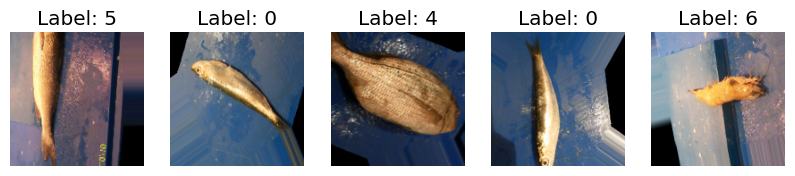

In [ ]:
batch = next(train_generator)
images, labels = batch
num_images = min(5, len(images))

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.show()

### 4.3. Creation of the ANN Architecture

**The following operations have been performed:**

1. **Data Augmentation**

     Data augmentation was applied for this model; however, it negatively impacted performance and was therefore not used in the final modeling stage.

1. **Techniques Implemented to Prevent Overfitting**

    Train and validation datasets used to train the ANN model. Dropout and batch normalization are applied to prevent overfitting.
  
    `Dropout` is a regularization technique used in neural networks that randomly sets a fraction of the neurons to zero during training, helping to prevent overfitting by ensuring the model does not become too reliant on any single feature.
  
    `Batch normalization` normalizes the inputs of each layer in the neural network by adjusting and scaling the activations, which accelerates training, reduces sensitivity to initialization and helps mitigate overfitting by providing some regularization effect.
  
2. **Early stopping, Learning rate decay and tensorboard callbacks used.**
  
   - To avoid prolonging the training duration, an `early stopping callback` was used. Training will be terminated if no improvement is observed after 6 epochs

   - A `checkpoint callback` was implemented to save the best model. The checkpoint callback monitored and saved the model with the lowest validation loss. To save  space, models were not saved separately but overwritten instead.

   - `The learning rate decay callback (ReduceLROnPlateau)` helps the model continue learning by reducing the learning rate if there is no improvement after 4 epochs.

   - To visualize the training process, a `TensorBoard callback` was utilized. However, since the TensorBoard callback does not work on Kaggle notebooks, the history object was used for visualization instead.
  
4. **Determining the necessary hyperparameters.**

    The model was initially trained without any regularization techniques, leading to overfitting. Subsequently, batch normalization and dropout were applied to stabilize the model. Since deeper models in ANNs are known to learn better, a 10-layer deep model was initially developed. However, due to out-of-memory errors in the Kaggle notebook, a 6-layer model was ultimately chosen. Similarly, increasing the batch size and image size hyperparameters resulted in out-of-memory errors. For these reasons, the final model architecture is presented below.
    
    ```
        - Number of Layers: 6
        - Number of Neurons: 512, 256, 256, 128, 64, 10
        - Batch size: 32
        - Activation Function: relu
        - Optimization Algorithm: Adam
        - Learning Rate: 0.01 with decay
        - Image size: 128 x 128
    ```

  
    
    ReLU and Leaky ReLU were tested as activation functions, while Adam and RMSProp were tried as optimization algorithms. The best results were achieved using ReLU and Adam.
      
    These hyperparameters can be tuned using algorithms such as Bayesian or randomized search. However, due to the long training times of deep learning models and the limited resources in our working environment, these adjustments have been made manually. In a cloud-based structure, hyperparameter tuning can be performed using distributed parallel processing.

  
5. **Selecting Performance Metric**

    Since all classes in the dataset are evenly distributed, accuracy has been chosen as the metric during training. `Accuracy` generally indicates how well the model makes predictions.


$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}
$$

    True Positive (TP): Correctly predicted positive instances.
    True Negative (TN): Correctly predicted negative instances.
    False Positive (FP): Incorrectly predicted positive instances.
    False Negative (FN): Incorrectly predicted negative instance



6. **Using Class Structure with Keras Functional API**
   
- The Functional API offers the ability to customize model architecture in a more detailed and flexible way. This is especially useful when creating more complex and customized network structures.
  
- More complex models may require features like multiple inputs and outputs, shared layers, or skip connections. The Functional API provides the necessary flexibility to manage such architectures.
  
- Using the Functional API in model design allows for gaining experience in working with more complex structures. This helps develop a habit for building more advanced network architectures in the future. This way, one can master a broader range of models without being limited to the Sequential API.

In [41]:
@saving.register_keras_serializable()
class CustomANN(Model):
    def __init__(self, input_shape=(150, 150, 3), num_classes=9, name="custom_ann", **kwargs):
        super(CustomANN, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.flatten = Flatten()

        self.fc1 = Dense(512, activation="relu")
        self.bn1 = BatchNormalization()
        self.dr1 = Dropout(0.4)

        self.fc2 = Dense(256, activation="relu")
        self.bn2 = BatchNormalization()
        self.dr2 = Dropout(0.3)

        self.fc3 = Dense(256, activation="relu")
        self.bn3 = BatchNormalization()
        self.dr3 = Dropout(0.3)

        self.fc4 = Dense(128, activation="relu")
        self.bn4 = BatchNormalization()
        self.dr4= Dropout(0.2)

        self.fc5 = Dense(64, activation="relu")
        self.bn5 = BatchNormalization()
        self.dr5 = Dropout(0.1)

        self.fc6 = Dense(num_classes, activation="softmax", dtype="float32")

    def call(self, inputs, training=False):
        x = self.flatten(inputs)

        x = self.fc1(x)
        x = self.bn1(x, training=training)
        x = self.dr1(x, training=training)

        x = self.fc2(x)
        x = self.bn2(x, training=training)
        x = self.dr2(x, training=training)

        x = self.fc3(x)
        x = self.bn3(x, training=training)
        x = self.dr3(x, training=training)

        x = self.fc4(x)
        x = self.bn4(x, training=training)
        x = self.dr4(x, training=training)

        x = self.fc5(x)
        x = self.bn5(x, training=training)
        x = self.dr5(x, training=training)

        outputs = self.fc6(x)
        return outputs

    def get_config(self):
        config = super(CustomANN, self).get_config()
        config.update({
            "input_shape": self.input_shape,
            "num_classes": self.num_classes
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def train(self, train_dir, val_dir, batch_size=32, epochs=10):

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            # rotation_range=40,
            # width_shift_range=0.2,
            # height_shift_range=0.2,
            # shear_range=0.2,
            # zoom_range=0.2,
            # horizontal_flip=True,
            # fill_mode="nearest"
        )

        validation_datagen = ImageDataGenerator(rescale=1./255)

        target_size = self.input_shape[:2]

        train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode="categorical",
            color_mode="rgb",
            shuffle=True,
        )

        validation_generator = validation_datagen.flow_from_directory(
            val_dir,
            target_size=target_size,
            batch_size=batch_size,
            class_mode="categorical",
            color_mode="rgb",
            shuffle=False,
        )

        checkpoint_val_loss = ModelCheckpoint(
            filepath="/kaggle/working/models/best_model.keras",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            verbose=1
        )


        early_stopping_callback = EarlyStopping(
            monitor="val_loss",
            patience=6,
            verbose=1
        )

        lr_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=4,
            min_lr = 0.00001,
            verbose=1)


        optimizer = RMSprop(learning_rate=0.001)

        self.compile(optimizer=optimizer,
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

        history = self.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=[checkpoint_val_loss, early_stopping_callback, lr_callback],
        )

        return history

In [47]:
train_dir = "/kaggle/working/final_model_dataset/train"
val_dir = "/kaggle/working/final_model_dataset/validation"

# Get the number of classes from the training generator
num_classes_from_generator = len(train_generator.class_indices)

model = CustomANN(input_shape=(128, 128, 3), num_classes=num_classes_from_generator)

# Ensure the models directory exists before training starts
model_output_dir_path = "/kaggle/working/models"
os.makedirs(model_output_dir_path, exist_ok=True)

result = model.train(train_dir=train_dir, val_dir=val_dir, batch_size=32, epochs=200)

Found 324 images belonging to 2 classes.
Found 82 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6064 - loss: 0.7868
Epoch 1: val_loss improved from inf to 2.74865, saving model to /kaggle/working/models/best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.6078 - loss: 0.7864 - val_accuracy: 0.4512 - val_loss: 2.7487 - learning_rate: 0.0010
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7096 - loss: 0.6114
Epoch 2: val_loss improved from 2.74865 to 1.80705, saving model to /kaggle/working/models/best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.7091 - loss: 0.6152 - val_accuracy: 0.5000 - val_loss: 1.8070 - learning_rate: 0.0010
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7601 - loss: 0.5419
Epoch 3: val_loss did not improve from 1.80705
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.7582 - loss: 0.5475 - val_accuracy: 0.4512 - val_loss: 3.2742 - learning_rate: 0.0010
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7608 - l

**fish_classification_ann_model**

In [48]:
model = load_model("/kaggle/working/models/best_model.keras")
# model = load_model("/kaggle/input/fish_classification_ann_model/keras/default/1/best_model.keras")



In [49]:
model.summary()

Model: "custom_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,816,774 (193.85 MB)

 Trainable params: 25,407,170 (96.92 MB)

 Non-trainable params: 2,432 (9.50 KB)

 Optimizer params: 25,407,172 (96.92 MB)

**Visualize with Tensorboard**

In [ ]:
# %tensorboard --logdir logs/fit

**Visualize with History**

In [50]:
def plot_training_history(result: Dict[str, list]) -> None:
    """
    Plots the training and validation loss and accuracy graphs from the model's training history.

    Parameters:
    -----------
    result : Dict[str, list]
        A dictionary containing the history of the model's training and validation metrics.
        It should include at least the following keys:
        - 'loss': List of training loss values.
        - 'val_loss': List of validation loss values.
        - 'accuracy': List of training accuracy values.
        - 'val_accuracy': List of validation accuracy values.

    Returns:
    --------
    None
        This function does not return any value, it just displays the plots.
    """

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(result.history['loss'], label='Train Loss')
    plt.plot(result.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result.history['accuracy'], label='Train Accuracy')
    plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

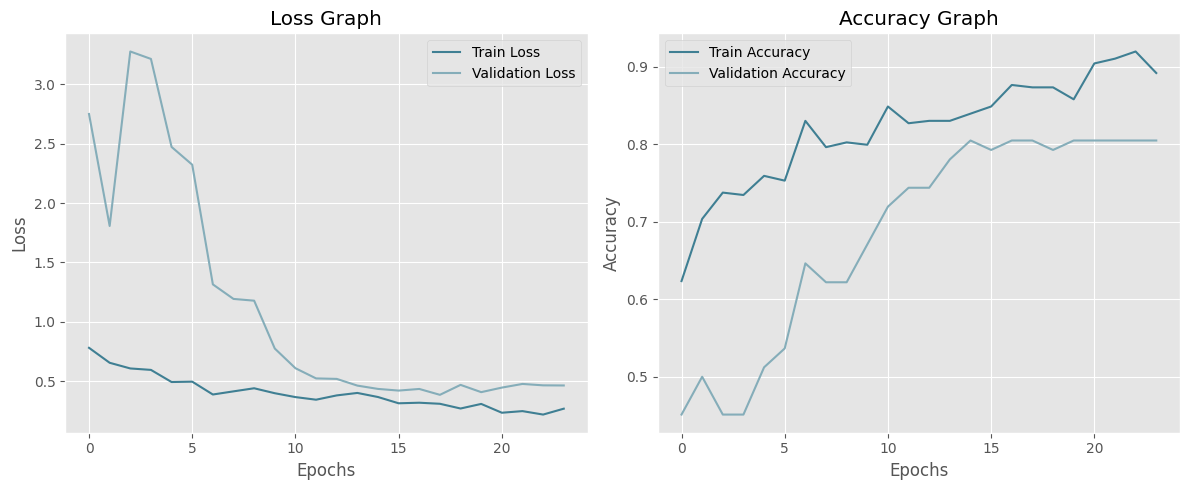

In [51]:
plot_training_history(result)

### 4.4. Model Evaluation

The following tasks have been carried out:

- After training is completed, the model's performance is evaluated on the test set.
  
- The performance of the model is analyzed using metrics such as classification accuracy, confusion matrix, accuracy, precision, and recall.
  
- Errors are examined by visualizing the examples that the model misclassified.

**After the test data is formatted appropriately and predictions are made, the performance metrics have been calculated.**



**Evaluation Metrics**

**Precision:**

- **Definition:** The ratio of true positive predictions to all positive predictions (true positives + false positives).
- **Formula:**
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

**Recall:**

- **Definition:** The ratio of true positives to all positive cases (true positives + false negatives).
- **Formula:**
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

**Accuracy:**

- **Definition:** The ratio of correct predictions to the total predictions.
- **Formula:**
  $$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  $$


**Confusion Matrix and Classification Report Insights:**

**Overall Metrics:**

`Accuracy:` 0.91 (91%) - The model correctly classified 91% of the images across all classes.

`Macro Average Precision:` 0.91 - Average precision across all classes, not considering class imbalance.

`Macro Average Recall:` 0.91 - Average recall across all classes, meaning that on average, the model correctly identifies 91% of true positives.

---

**Class-Level Insights:**

- `Class 0 (Black Sea Sprat):` High recall (0.98) indicates the model correctly identifies most instances, and precision (0.91) shows it makes few false positive errors.
  
- `Class 1 (Gilt-Head Bream):` Moderate precision (0.86) and recall (0.81) indicate a higher rate of both false positives and false negatives compared to Class 0.

- `Class 2 (Horse Mackerel):` High precision (0.93) and recall (0.97) indicate excellent performance, with very few errors.

- `Class 3 (Red Mullet):` Nearly perfect recall (0.99) and high precision (0.98) demonstrate strong performance with minimal errors.

- `Class 4 (Red Sea Bream):` Lower recall (0.85) and moderate precision (0.88) suggest that some instances are misclassified, though the performance is still acceptable.

- `Class 5 (Sea Bass):` Precision (0.83) and recall (0.83) show balanced performance, but there is room for improvement in reducing both false positives and false negatives.

- `Class 6 (Shrimp):` High recall (0.97) and precision (0.93) indicate strong performance, with only minor misclassification.

- `Class 7 (Striped Red Mullet):` Balanced recall (0.86) and precision (0.86) indicate consistent performance, but a higher error rate than top-performing classes.

- `Class 8 (Trout):` High precision (0.91) and recall (0.93) indicate strong identification with only a small number of errors.

---

**Conclusion:**

The model performs well overall, particularly with `Class 2 (Horse Mackerel)`, `Class 3 (Red Mullet)` and `Class 6 (Shrimp)`. However, some classes such as `Class 1 (Gilt-Head Bream)` and `Class 4 (Red Sea Bream)` show relatively lower performance, which might benefit from further optimization, such as model fine-tuning or additional training data.

**The model achieved 91% accuracy by correctly classifying 918 out of 1,000 test samples.**

**Since there is no class imbalance, an averaging method that gives equal importance to each class can be preferred. In this case, `average='macro'` would be appropriate on precission and recall score.**


In [52]:
def evaluate_model(
    model,
    test_dir: str,
    target_size: tuple = (128, 128),
    batch_size: int = 32
) -> None:
    """
    Evaluate the model on the test dataset and display performance metrics.

    Parameters:
    model: The trained model to evaluate.
    test_dir (str): Directory path to the test dataset.
    target_size (tuple): Target size for the input images (height, width).
    batch_size (int): Number of images to process in each batch.

    Returns:
    None: This function prints the accuracy, precision, recall, and displays
          confusion matrix and classification report.
    """


    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(test_generator)

    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = test_generator.classes

    # Performance Metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')
    recall = recall_score(true_classes, predicted_classes, average='macro')

    print("Accuracy:", accuracy)
    print("Precision (macro):", precision)
    print("Recall (macro):", recall)

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # Classification Report
    print(classification_report(true_classes, predicted_classes))

    return test_generator ,predicted_classes


Found 100 images belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Accuracy: 0.84
Precision (macro): 0.8658088235294117
Recall (macro): 0.823051948051948


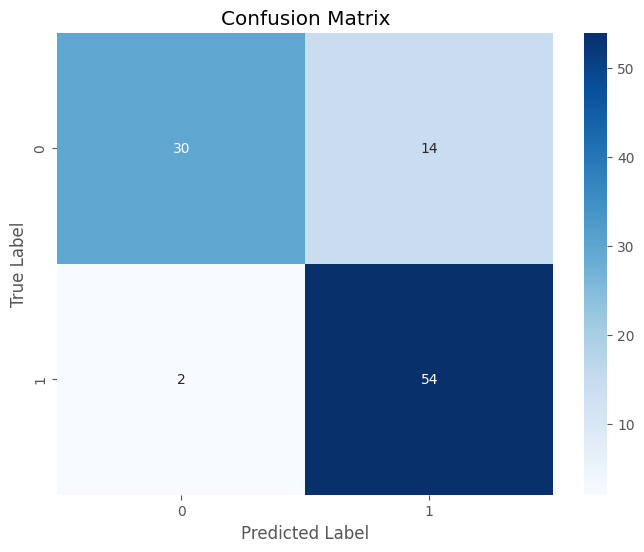

              precision    recall  f1-score   support

           0       0.94      0.68      0.79        44
           1       0.79      0.96      0.87        56

    accuracy                           0.84       100
   macro avg       0.87      0.82      0.83       100
weighted avg       0.86      0.84      0.84       100



In [53]:
test_directory = "/kaggle/working/final_model_dataset/test"
test_generator, predicted_classes = evaluate_model(model, test_directory)

**Analyze Misclassifications**

In [54]:
def analyze_and_visualize_misclassifications(test_generator, predicted_classes, num_samples=10) -> None:
    """
    Analyze and visualize misclassified images from the test dataset.

    Parameters:
    test_generator: The generator used to load the test data.
    predicted_classes: The predicted class indices from the model.
    num_samples: The number of misclassified images to display.

    Returns:
    None: This function prints the total number of misclassified images and shows a plot of some misclassified examples.
    """

    test_generator.reset()

    df = pd.DataFrame({
        'filename': test_generator.filenames,
        'predict': predicted_classes,
        'y': test_generator.classes
    })
    misclassified = df[df['y'] != df['predict']]
    total_misclassified = misclassified.shape[0]

    print(f'Total misclassified images: {total_misclassified}')
    print("\nMisclassified Images:")
    print(misclassified)

    if total_misclassified > 0:

        samples_to_display = min(num_samples, total_misclassified)
        misclassified_samples = misclassified.sample(samples_to_display)

        cols = 5
        rows = (samples_to_display + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

        for ax, (_, row) in zip(axes.flatten(), misclassified_samples.iterrows()):
            img_path = test_generator.directory + '/' + row['filename']
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(f'True: {row["y"]}, Pred: {row["predict"]}')
            ax.axis('off')

        for i in range(samples_to_display, len(axes.flatten())):
            axes.flatten()[i].axis('off')

        plt.tight_layout()
        plt.show()

Total misclassified images: 16

Misclassified Images:
                          filename  predict  y
2      merisiig/H201703_fish_1.jpg        1  0
6      merisiig/K202001_fish_1.jpg        1  0
7      merisiig/K202001_fish_1.png        1  0
8      merisiig/K202002_fish_1.jpg        1  0
9      merisiig/K202002_fish_1.png        1  0
10    merisiig/KN201701_fish_1.jpg        1  0
11    merisiig/KN201701_fish_1.png        1  0
12    merisiig/KU201705_fish_1.jpg        1  0
13    merisiig/KU201705_fish_1.png        1  0
14     merisiig/R202007_fish_1.jpg        1  0
16     merisiig/R202010_fish_1.jpg        1  0
17     merisiig/R202010_fish_1.png        1  0
18     merisiig/R202106_fish_1.jpg        1  0
20     merisiig/S202001_fish_1.jpg        1  0
66  siirdesiig/NJ202001_fish_1.jpg        0  1
67  siirdesiig/NJ202001_fish_1.png        0  1


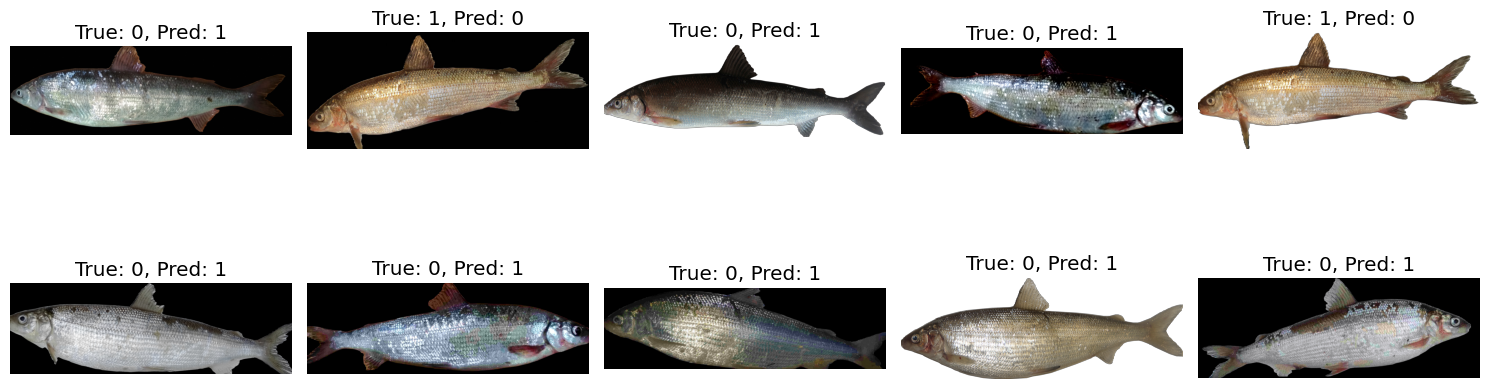

In [55]:
analyze_and_visualize_misclassifications(test_generator, predicted_classes, num_samples=10)

### 4.5. **Prediction**

A random image for each fish in the test folder has been selected and compiled into a list and it was observed that the model successfully made accurate predictions for fish species.

In [56]:
def predict_single_image(model, image_path, test_generator):
    """
    Predict the class of a single image using a trained model.

    Parameters:
    model: The trained Keras model for image classification.
    image_path: Path to the image to be classified.
    test_generator: Keras ImageDataGenerator flow generator.

    Returns:
    None: This function displays the image and prints the predicted class with confidence.
    """
    image = load_img(image_path, target_size=(128, 128))
    plt.imshow(image)
    plt.title(f"Selected Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions, axis=1)[0]

    class_indices = test_generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    predicted_label = class_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    print(f"Predicted Label: {predicted_label} (Confidence: {confidence:.2f})")


**Prediction list for each class from the test image directory**

In [57]:
test_folder = "/kaggle/working/final_model_dataset/test"
test_df = df_from_image_folders(test_folder, extensions=["jpg", "png"])
prediction_list = test_df.groupby("label")["path"].sample(1).to_list()

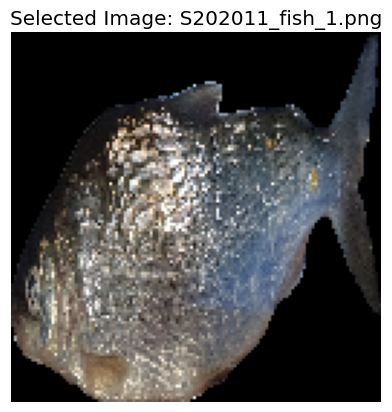

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Predicted Label: merisiig (Confidence: 0.94)
Actual label: merisiig
                                                  
**************************************************


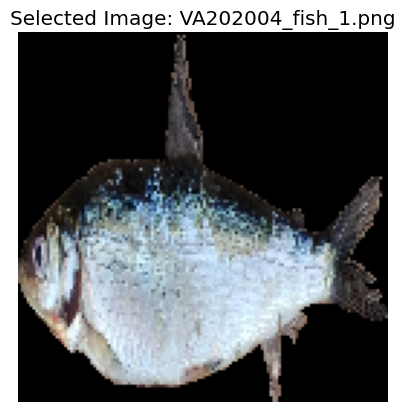

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Label: siirdesiig (Confidence: 0.88)
Actual label: siirdesiig
                                                  
**************************************************


In [58]:
for image in prediction_list:
    class_name = os.path.basename(os.path.dirname(image))
    predict_single_image(model, image, test_generator)
    print(f"Actual label: {class_name}")
    print(50 * " ")
    print(50 * "*")

## 5. Conclusions and Recommendations

The results of this study indicate that the simple Artificial Neural Network (ANN) model successfully classified fish species from images with %91 accuracy.

**Recommendations:**

- Model Enhancement: The number of layers and dropout rates of the ANN model can be adjusted to achieve better results. Due to out-of-memory errors, no attempts were made after reaching 91% accuracy. Additionally, CNN layers can be added to the model, or transfer learning can be performed using well-known model architectures to achieve better results.
  
- Hyperparameter Tuning: Automating hyperparameter tuning using Bayesian optimization or grid search could lead to better model performance.
  
- Scaling Resources: If computational resources allow, parallel processing or cloud-based solutions can be used for faster model training and hyperparameter search.
  